In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime


from datetime import timedelta, datetime, date
import calendar

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
import glob


# This is my preprocessing function, which I run on each grib file

# Load, preprocess, append, and concatenate all the grib files. In this notebook I ran it on half of the data available.

### I will comment the code below for pr_sfc. I repeat the code for each variable separiately. I could loop it for a list of varname =[ 'pr_sfc' , ....] but I preferred keeping it separate.

In [2]:
!ls /Data2/SubX/EMC/GEFS/forecast/

20170622  20171025  20180613  20190130	20190918  20200506
20170624  20171101  20180620  20190206	20190925  20200513
20170625  20171108  20180627  20190213	20191002  20200520
20170626  20171115  20180704  20190220	20191009  20200527
20170627  20171122  20180711  20190227	20191016  20200603
20170629  20171129  20180718  20190306	20191023  20200610
20170630  20171206  20180725  20190313	20191030  20200617
20170701  20171213  20180801  20190320	20191106  20200624
20170702  20171220  20180808  20190327	20191113  20200701
20170703  20171227  20180815  20190403	20191120  20200708
20170704  20180103  20180822  20190410	20191127  20200715
20170705  20180110  20180829  20190417	20191204  20200722
20170712  20180117  20180905  20190424	20191211  20200729
20170718  20180124  20180912  20190501	20191218  20200805
20170719  20180131  20180919  20190508	20191225  20200812
20170725  20180207  20180926  20190515	20200101  20200819
20170726  20180214  20181003  20190522	20200108  20200826
20170801  2018

In [3]:
from glob import glob
variable_names = ['pr_sfc']

def ppf2_filename(ds,filename):
    # rename coordinates
    ds  = ds.rename({ 'lon_0':'lon', 'lat_0':'lat', 'forecast_time0':'time'})
    # getting start time from file name
    ts = filename.split('_')
#     print(ts)
    whereGEFS = ts.index('GEFS')
#     print(whereGEFS)
    dateSstr = ts[whereGEFS+1]
#     print(dateSstr)
    dateS = datetime.strptime(dateSstr, '%d%b%Y')
#     print(dateS)
    
    Mvalue = np.int(float(np.asarray(ts[-1][2:4])))

    ds.coords['S'] = 'S', np.atleast_1d(dateS)
    ds.coords['M'] = 'M', np.atleast_1d(Mvalue)
    
    ds.coords['time']=np.array([  43200000000000,  129600000000000,  216000000000000,
        302400000000000,  388800000000000,  475200000000000,
        561600000000000,  648000000000000,  734400000000000,
        820800000000000,  907200000000000,  993600000000000,
       1080000000000000, 1166400000000000, 1252800000000000,
       1339200000000000, 1425600000000000, 1512000000000000,
       1598400000000000, 1684800000000000, 1771200000000000,
       1857600000000000, 1944000000000000, 2030400000000000,
       2116800000000000, 2203200000000000, 2289600000000000,
       2376000000000000, 2462400000000000, 2548800000000000,
       2635200000000000, 2721600000000000, 2808000000000000,
       2894400000000000, 2980800000000000],
      dtype='timedelta64[ns]')

    # select US
    ds = ds.sel(lat=slice(50,23), lon=slice(230,300))
#     print(ds)
    return ds

def read_netcdfs(files, dim, transform_func=None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
#         print(path)
        with xr.open_dataset(path, engine='pynio', chunks={}) as ds:
            # transform_func should do some sort of selection or
            # aggregation
            if transform_func is not None:
                ds = transform_func(ds, path)
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
#             print(ds)
#             pause
#             ds.load()
            return ds
    print(files)
    paths = sorted(glob(files))
#     print(paths)
#     pause
    datasets = [process_one_path(p) for p in paths]
    
    combined = xr.combine_by_coords(datasets)
    combined = combined.chunk({'S':4,'M':-1})
    return combined

var_l=[]
for ivx, ivar in enumerate(variable_names):
    print(ivar)
    c_l = []
    for iy in np.arange(2017, 2021):#2017
        print(iy)
        # here we suppose we only care about the combined mean of each file;
        # you might also use indexing operations like .sel to subset datasets
        combined = read_netcdfs('/Data2/SubX/EMC/GEFS/forecast/'+np.str(iy)+'*/'+ivar+'*.grb2', dim=['S','M'],
                                transform_func=ppf2_filename)

        c_l.append(combined)
    all_values = xr.concat(c_l, dim='S') 
    var_l.append(all_values)


pr_sfc
2017
/Data2/SubX/EMC/GEFS/forecast/2017*/pr_sfc*.grb2
2018
/Data2/SubX/EMC/GEFS/forecast/2018*/pr_sfc*.grb2
2019
/Data2/SubX/EMC/GEFS/forecast/2019*/pr_sfc*.grb2
2020
/Data2/SubX/EMC/GEFS/forecast/2020*/pr_sfc*.grb2


In [4]:
all_variables = xr.merge(var_l)
all_variables

<xarray.Dataset>
Dimensions:          (M: 10, S: 181, lat: 28, lon: 71, time: 35)
Coordinates:
  * M                (M) int64 0 1 2 3 4 5 6 7 8 9
  * lon              (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * time             (time) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
  * lat              (lat) float32 50.0 49.0 48.0 47.0 ... 26.0 25.0 24.0 23.0
  * S                (S) datetime64[ns] 2017-06-30 2017-07-01 ... 2020-10-14
Data variables:
    APCP_P1_L1_GLL0  (S, M, time, lat, lon) float32 dask.array<chunksize=(4, 10, 35, 28, 71), meta=np.ndarray>

In [5]:
all_variables = all_variables.rename({'APCP_P1_L1_GLL0':'pr_sfc'})

In [6]:
all_variables

<xarray.Dataset>
Dimensions:  (M: 10, S: 181, lat: 28, lon: 71, time: 35)
Coordinates:
  * M        (M) int64 0 1 2 3 4 5 6 7 8 9
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * time     (time) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
  * S        (S) datetime64[ns] 2017-06-30 2017-07-01 ... 2020-09-23 2020-10-14
Data variables:
    pr_sfc   (S, M, time, lat, lon) float32 dask.array<chunksize=(4, 10, 35, 28, 71), meta=np.ndarray>

In [7]:
all_variables.load()

<xarray.Dataset>
Dimensions:  (M: 10, S: 181, lat: 28, lon: 71, time: 35)
Coordinates:
  * M        (M) int64 0 1 2 3 4 5 6 7 8 9
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * time     (time) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
  * S        (S) datetime64[ns] 2017-06-30 2017-07-01 ... 2020-09-23 2020-10-14
Data variables:
    pr_sfc   (S, M, time, lat, lon) float32 0.11 0.0 0.0 ... 3.0 2.8 4.2000003

In [8]:
# all_variables.coords['target_time'] = all_variables.S+all_variables.time
# 

In [9]:
MASK_url = 'http://iridl.ldeo.columbia.edu/expert/SOURCES/.Models/.SubX/'
MASK_url1 = '/.hindcast/.pr'
MASK_url2 = '/dup/.SOURCES/.Features/.Political/.World/.Countries/.the_geom/objectid/135/VALUE/rasterize/dods'
url3 = '/Y/(23N)/(50N)/RANGEEDGES/X/(130W)/(60W)/RANGEEDGES'  

i_v_u ='EMC/.GEFS'
#                'GMAO/.GEOS_V2p1',
#                'NRL/.NESM',
#                'RSMAS/.CCSM4',
#                'NCEP/.CFSv2'
              #]

ds_mask = xr.open_dataset(MASK_url+i_v_u+MASK_url1+url3+MASK_url2)
ds_mask['the_geom']=xr.where(ds_mask.the_geom!=0, 1, 0)

ds_mask = ds_mask.rename({'X':'lon', 'Y':'lat'})
ds_mask = ds_mask.isel(objectid=0, drop=True)
ds_mask.coords['lon'] = ds_mask.lon+360.



# re do this with accumulated 3 day rainfall. The accumulation (rolling sum) is done along L

In [10]:
all_variables_3L = all_variables.rolling(time=3).sum()


# Here I switch to the left edge of the interval

In [11]:
all_variables_3L.coords['time'] = all_variables_3L.time.values-np.timedelta64(2,'D')

# And drop the first 2 empty values

In [12]:
all_variables_3L = all_variables_3L.isel(time=slice(2,36))
all_variables_3L.pr_sfc[0,0,:,10,20]

<xarray.DataArray 'pr_sfc' (time: 33)>
array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.3000000e+00,
       4.3000002e+00, 4.3000002e+00, 2.1000001e+00, 1.0000014e-01,
       1.1000014e-01, 1.0000147e-02, 1.0000147e-02, 1.4714897e-07,
       1.4714897e-07, 1.4714897e-07, 1.4714897e-07, 1.4714897e-07,
       1.4714897e-07, 1.4714897e-07, 2.0000014e-01, 1.0400001e+00,
       1.2400000e+00, 1.3400000e+00, 5.0000006e-01, 3.1000006e-01,
       1.0000080e-02, 1.0000080e-02, 8.0093741e-08, 8.0093741e-08,
       8.0093741e-08], dtype=float32)
Coordinates:
    M        int64 0
    lon      float32 250.0
  * time     (time) timedelta64[ns] 0 days 12:00:00 ... 32 days 12:00:00
    lat      float32 40.0
    S        datetime64[ns] 2017-06-30

# Update the target time, because those have not changed and they are still linked to the right edge of the interval

In [13]:
all_variables_3L.coords['target_time'] = all_variables_3L.S+all_variables_3L.time
all_variables_3L

<xarray.Dataset>
Dimensions:      (M: 10, S: 181, lat: 28, lon: 71, time: 33)
Coordinates:
  * M            (M) int64 0 1 2 3 4 5 6 7 8 9
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * time         (time) timedelta64[ns] 0 days 12:00:00 ... 32 days 12:00:00
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * S            (S) datetime64[ns] 2017-06-30 2017-07-01 ... 2020-10-14
    target_time  (S, time) datetime64[ns] 2017-06-30T12:00:00 ... 2020-11-15T12:00:00
Data variables:
    pr_sfc       (S, M, time, lat, lon) float32 8.82 5.0999994 ... 7.5000043

In [14]:
all_variables_T3 = all_variables_3L.stack(St=('S','time'))
all_variables_T3 = all_variables_T3.swap_dims({'St':'target_time'})
all_variables_T3 = all_variables_T3.unstack()


In [15]:
all_variables_T3

<xarray.Dataset>
Dimensions:      (M: 10, lat: 28, lon: 71, target_time: 5973)
Coordinates:
  * M            (M) int64 0 1 2 3 4 5 6 7 8 9
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * target_time  (target_time) datetime64[ns] 2017-06-30T12:00:00 ... 2020-11-15T12:00:00
    St           (target_time) object (Timestamp('2017-06-30 00:00:00'), Timedelta('0 days 12:00:00')) ... (Timestamp('2020-10-14 00:00:00'), Timedelta('32 days 12:00:00'))
Data variables:
    pr_sfc       (M, lat, lon, target_time) float32 8.82 9.44 ... 7.5000043

In [16]:
trend_unstacked = xr.open_dataset('harmonics_from_quantiles_cauchyB.nc')
trend_unstackedroll = xr.open_dataset('harmonics_from_quantiles_cauchyrollB.nc')

In [17]:
!ls -ltran harmonics_from_quantiles*

-rw-rw-r--. 1 9809 9809 968452 Jun 26 17:17 harmonics_from_quantiles.nc
-rw-rw-r--. 1 9809 9809 458782 Jun 30 13:56 harmonics_from_quantiles_arctan.nc
-rw-rw-r--. 1 9809 9809 458782 Jun 30 13:56 harmonics_from_quantiles_soft.nc
-rw-rw-r--. 1 9809 9809 458782 Jun 30 14:07 harmonics_from_quantiles_cauchy.nc
-rw-rw-r--. 1 9809 9809 458782 Jul  1 09:59 harmonics_from_quantiles_cauchyB.nc
-rw-rw-r--. 1 9809 9809 458782 Jul  1 09:59 harmonics_from_quantiles_cauchyrollB.nc
-rw-rw-r--. 1 9809 9809 236126 Jul  2 16:43 harmonics_from_quantiles_cauchy_LongL.nc
-rw-rw-r--. 1 9809 9809 681087 Aug 19 12:12 harmonics_from_quantiles_cauchy_aug2020.nc
-rw-rw-r--. 1 9809 9809 681087 Aug 19 12:12 harmonics_from_quantiles_cauchy_smoothedspace_aug2020.nc
-rw-rw-r--. 1 9809 9809 681087 Aug 19 12:12 harmonics_from_quantiles_soft_aug2020.nc


In [18]:
# trend_unstacked = xr.open_dataset('harmonics_from_quantiles_cauchy.nc')

In [19]:
trend_unstacked_LongL = xr.open_dataset('harmonics_from_quantiles_cauchy_LongL.nc')

In [20]:
def apply_fffourier(dsin):
    x = dsin.target_clim.dt.dayofyear.values
#     print(dsin)
#     print(x.shape)
    popt = dsin.H.values
    out = fffourierB(x, *popt)
#     print(out)
#     pause
#     print(popt)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(out)
def fffourierB(x, *a_in):
    '''harmonic with np.exp(sum(sine and cosine))'''
    a_0 = a_in[0]
    len_a = len(a_in)-1
#     print(len_a, int(len_a/2))
    if len_a==3:
        a = a_in[1]
        b = a_in[2]
    else:
        a = a_in[1:int(len_a/2+1)]
        b = a_in[int(len_a/2+1):]
#     print(a,b)
    tau = 365.25
    nu = 2*np.pi/tau
    ret = a_0
    for deg in range(0,int(len_a/2)):
#         print(deg)
#         print(a[deg] , b[deg] )
        ret += a[deg] * np.sin((deg+1) * nu * x) + b[deg] * np.cos((deg+1) * nu * x)
#     if any(np.abs(a))>=19:
#         ret*=10000
#     if any(np.abs(b))>=19:
#         ret*=10000
    return np.exp(ret)

In [21]:
target_all = pd.date_range('1900-01-01', periods=365, freq='D')
target_all1 = [pd.DatetimeIndex([it]) for it in target_all]


In [22]:
trend_unstacked

<xarray.Dataset>
Dimensions:      (Lbeg: 4, harmonic: 7, lat: 28, lon: 71, target_clim: 365)
Coordinates:
  * harmonic     (harmonic) int64 0 1 2 3 4 5 6
  * Lbeg         (Lbeg) int64 2 4 6 8
  * lat          (lat) float64 23.0 24.0 25.0 26.0 27.0 ... 47.0 48.0 49.0 50.0
  * lon          (lon) float64 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    H            (harmonic, Lbeg, lat, lon) float64 ...

In [23]:
stack1 = trend_unstacked.stack(allpoints=['Lbeg','lat','lon'])  
smooth_clim = stack1.groupby('allpoints').apply(apply_fffourier)
smooth_clim = smooth_clim.unstack('allpoints')
smooth_clim = smooth_clim.rename({'dim_0':'target_clim'})
smooth_clim.coords['target_clim'] = 'target_clim',target_all
smooth_clim_cauchy = smooth_clim.to_dataset(name='pr_sfc')

In [24]:
stack1 = trend_unstacked_LongL.stack(allpoints=['Lbeg','lat','lon'])  
smooth_clim = stack1.groupby('allpoints').apply(apply_fffourier)
smooth_clim = smooth_clim.unstack('allpoints')
smooth_clim = smooth_clim.rename({'dim_0':'target_clim'})
smooth_clim.coords['target_clim'] = 'target_clim',target_all
smooth_clim_cauchy_LongL = smooth_clim.to_dataset(name='pr_sfc')

In [25]:
stack1 = trend_unstackedroll.stack(allpoints=['Lbeg','lat','lon'])  
smooth_clim = stack1.groupby('allpoints').apply(apply_fffourier)
smooth_clim = smooth_clim.unstack('allpoints')
smooth_clim = smooth_clim.rename({'dim_0':'target_clim'})
smooth_clim.coords['target_clim'] = 'target_clim',target_all
smooth_clim_cauchyroll = smooth_clim.to_dataset(name='pr_sfc')

In [26]:
smooth_clim_cauchy = xr.open_dataset('smooth_clim_cauchy_oct2020.nc')
smooth_clim_cauchy

<xarray.Dataset>
Dimensions:      (Lbeg: 6, lat: 28, lon: 71, target_clim: 365)
Coordinates:
  * Lbeg         (Lbeg) object '14-33' '4-12' '4-22' '4-33' '6-14' '8-16'
  * lat          (lat) float64 23.0 24.0 25.0 26.0 27.0 ... 47.0 48.0 49.0 50.0
  * lon          (lon) float64 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    pr_sfc       (target_clim, Lbeg, lat, lon) float64 ...

In [27]:
# looping through the target dates for climatologies
import warnings
warnings.filterwarnings("ignore")

# check_85LL = []
check_85S_LL = []
for iT in target_all1:
    # extract values that correspond to the target dates
    temp = all_variables_T3.where((all_variables_T3.target_time.dt.month==iT.month.values[0])&
                              (all_variables_T3.target_time.dt.day==iT.day.values[0]), drop=True)
#     smooth_data = smooth_clim_cauchy.where((smooth_clim_cauchy.target_clim.dt.month==iT.month.values[0])&
#                               (smooth_clim_cauchy.target_clim.dt.day==iT.day.values[0]), drop=True)
    smooth_data = smooth_clim_cauchy.where((smooth_clim_cauchy.target_clim.dt.month==iT.month.values[0])&
                              (smooth_clim_cauchy.target_clim.dt.day==iT.day.values[0]), drop=True)
    # bits to extract the S and t of each target_time
    y_ls = [y for (x,y) in temp.St.values]
    y_arr = np.array(y_ls)
    # loop through the 3 types of lead times
    # I have the -1 because of the way the timedelta is centered at 0 day and 12hours for day 1
#     for different_lead1, different_lead2 in zip(np.array([1,7,13])-1, np.array([5,11,17])-1 ):
    check_85b  = []
#     for different_lead1, different_lead2 in zip(np.array([2,4,6,8])-1, np.array([10,12,14,16])-1 ):
    for different_lead1, different_lead2 in zip(np.array([8,10,12])-1, np.array([8,10,12]) ):
#     for different_lead1, different_lead2 in zip(np.array([4,14])-1, np.array([22,33])-1 ):
#         print(y_arr[(y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D'))])
        temp2 = temp.sel(target_time=
                         (y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D')))
        smooth_data2 = smooth_data.isel(Lbeg=0)
#         smooth_data2 = smooth_data.sel(Lbeg=different_lead1+1)
        smooth_data2 = smooth_data2.rename({'target_clim':'target_time'})
        temp3 = temp2.stack(values = ['M','target_time'])
        diff  =  - smooth_data2.isel(target_time=0) +temp3
        diffbool = xr.where(diff.pr_sfc.where(ds_mask.the_geom>0)<0, 0,1)
        diffbool = diffbool.where(ds_mask.the_geom>0).sum('values')/diffbool.where(ds_mask.the_geom>0).count('values')
        diffbool = diffbool.expand_dims('Lbeg')
        diffbool.coords['Lbeg'] = 'Lbeg', np.atleast_1d(different_lead1+1)
        diffbool = diffbool.expand_dims('target_time')
        check_85b.append(diffbool)
    check_85b = xr.combine_by_coords(check_85b)    
#     check_85LL.append(check_85b)
    check_85S_LL.append(check_85b)
    print(iT)
check_85S_LL14 = xr.combine_by_coords(check_85S_LL)    
# check_85LL = xr.combine_by_coords(check_85LL)    


DatetimeIndex(['1900-01-01'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-02'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-03'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-04'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-05'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-06'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-07'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-08'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-09'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-10'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-11'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-12'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-13'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-14'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-15'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-1

DatetimeIndex(['1900-05-08'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-09'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-10'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-11'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-12'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-13'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-14'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-15'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-16'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-17'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-18'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-19'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-20'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-21'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-22'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-2

DatetimeIndex(['1900-09-12'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-13'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-14'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-15'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-16'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-17'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-18'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-19'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-20'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-21'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-22'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-23'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-24'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-25'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-26'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-2

In [28]:
# looping through the target dates for climatologies
import warnings
warnings.filterwarnings("ignore")

# check_85LL = []
check_85S_LL = []
for iT in target_all1:
    # extract values that correspond to the target dates
    temp = all_variables_T3.where((all_variables_T3.target_time.dt.month==iT.month.values[0])&
                              (all_variables_T3.target_time.dt.day==iT.day.values[0]), drop=True)
#     smooth_data = smooth_clim_cauchy.where((smooth_clim_cauchy.target_clim.dt.month==iT.month.values[0])&
#                               (smooth_clim_cauchy.target_clim.dt.day==iT.day.values[0]), drop=True)
    smooth_data = smooth_clim_cauchy.where((smooth_clim_cauchy.target_clim.dt.month==iT.month.values[0])&
                              (smooth_clim_cauchy.target_clim.dt.day==iT.day.values[0]), drop=True)
    # bits to extract the S and t of each target_time
    y_ls = [y for (x,y) in temp.St.values]
    y_arr = np.array(y_ls)
    # loop through the 3 types of lead times
    # I have the -1 because of the way the timedelta is centered at 0 day and 12hours for day 1
#     for different_lead1, different_lead2 in zip(np.array([1,7,13])-1, np.array([5,11,17])-1 ):
    check_85b  = []
#     for different_lead1, different_lead2 in zip(np.array([2,4,6,8])-1, np.array([10,12,14,16])-1 ):
    for different_lead1, different_lead2 in zip(np.array([8,10,12])-1, np.array([8,10,12]) ):
#     for different_lead1, different_lead2 in zip(np.array([4,14])-1, np.array([22,33])-1 ):
#         print(y_arr[(y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D'))])
        temp2 = temp.sel(target_time=
                         (y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D')))
        smooth_data2 = smooth_data.isel(Lbeg=1)
#         smooth_data2 = smooth_data.sel(Lbeg=different_lead1+1)
        smooth_data2 = smooth_data2.rename({'target_clim':'target_time'})
        temp3 = temp2.stack(values = ['M','target_time'])
        diff  =  - smooth_data2.isel(target_time=0) +temp3
        diffbool = xr.where(diff.pr_sfc.where(ds_mask.the_geom>0)<0, 0,1)
        diffbool = diffbool.where(ds_mask.the_geom>0).sum('values')/diffbool.where(ds_mask.the_geom>0).count('values')
        diffbool = diffbool.expand_dims('Lbeg')
        diffbool.coords['Lbeg'] = 'Lbeg', np.atleast_1d(different_lead1+1)
        diffbool = diffbool.expand_dims('target_time')
        check_85b.append(diffbool)
    check_85b = xr.combine_by_coords(check_85b)    
#     check_85LL.append(check_85b)
    check_85S_LL.append(check_85b)
    print(iT)
check_85S_LL4 = xr.combine_by_coords(check_85S_LL)    
# check_85LL = xr.combine_by_coords(check_85LL)    


DatetimeIndex(['1900-01-01'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-02'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-03'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-04'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-05'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-06'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-07'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-08'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-09'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-10'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-11'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-12'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-13'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-14'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-15'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-1

DatetimeIndex(['1900-05-08'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-09'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-10'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-11'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-12'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-13'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-14'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-15'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-16'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-17'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-18'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-19'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-20'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-21'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-22'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-2

DatetimeIndex(['1900-09-12'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-13'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-14'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-15'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-16'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-17'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-18'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-19'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-20'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-21'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-22'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-23'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-24'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-25'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-26'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-2

In [29]:
# looping through the target dates for climatologies
import warnings
warnings.filterwarnings("ignore")

# check_85LL = []
check_85S_LL = []
for iT in target_all1:
    # extract values that correspond to the target dates
    temp = all_variables_T3.where((all_variables_T3.target_time.dt.month==iT.month.values[0])&
                              (all_variables_T3.target_time.dt.day==iT.day.values[0]), drop=True)
#     smooth_data = smooth_clim_cauchy.where((smooth_clim_cauchy.target_clim.dt.month==iT.month.values[0])&
#                               (smooth_clim_cauchy.target_clim.dt.day==iT.day.values[0]), drop=True)
    smooth_data = smooth_clim_cauchy.where((smooth_clim_cauchy.target_clim.dt.month==iT.month.values[0])&
                              (smooth_clim_cauchy.target_clim.dt.day==iT.day.values[0]), drop=True)
    # bits to extract the S and t of each target_time
    y_ls = [y for (x,y) in temp.St.values]
    y_arr = np.array(y_ls)
    # loop through the 3 types of lead times
    # I have the -1 because of the way the timedelta is centered at 0 day and 12hours for day 1
#     for different_lead1, different_lead2 in zip(np.array([1,7,13])-1, np.array([5,11,17])-1 ):
    check_85b  = []
#     for different_lead1, different_lead2 in zip(np.array([2,4,6,8])-1, np.array([10,12,14,16])-1 ):
    for different_lead1, different_lead2 in zip(np.array([8,10,12])-1, np.array([8,10,12]) ):
#     for different_lead1, different_lead2 in zip(np.array([4,14])-1, np.array([22,33])-1 ):
#         print(y_arr[(y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D'))])
        temp2 = temp.sel(target_time=
                         (y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D')))
        smooth_data2 = smooth_data.isel(Lbeg=3)
#         smooth_data2 = smooth_data.sel(Lbeg=different_lead1+1)
        smooth_data2 = smooth_data2.rename({'target_clim':'target_time'})
        temp3 = temp2.stack(values = ['M','target_time'])
        diff  =  - smooth_data2.isel(target_time=0) +temp3
        diffbool = xr.where(diff.pr_sfc.where(ds_mask.the_geom>0)<0, 0,1)
        diffbool = diffbool.where(ds_mask.the_geom>0).sum('values')/diffbool.where(ds_mask.the_geom>0).count('values')
        diffbool = diffbool.expand_dims('Lbeg')
        diffbool.coords['Lbeg'] = 'Lbeg', np.atleast_1d(different_lead1+1)
        diffbool = diffbool.expand_dims('target_time')
        check_85b.append(diffbool)
    check_85b = xr.combine_by_coords(check_85b)    
#     check_85LL.append(check_85b)
    check_85S_LL.append(check_85b)
    print(iT)
check_85S_LL433 = xr.combine_by_coords(check_85S_LL)    
# check_85LL = xr.combine_by_coords(check_85LL)    


DatetimeIndex(['1900-01-01'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-02'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-03'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-04'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-05'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-06'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-07'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-08'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-09'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-10'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-11'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-12'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-13'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-14'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-15'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-1

DatetimeIndex(['1900-05-08'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-09'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-10'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-11'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-12'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-13'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-14'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-15'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-16'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-17'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-18'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-19'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-20'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-21'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-22'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-2

DatetimeIndex(['1900-09-12'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-13'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-14'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-15'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-16'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-17'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-18'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-19'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-20'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-21'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-22'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-23'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-24'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-25'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-26'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-2

In [ ]:
check_85S_LL14

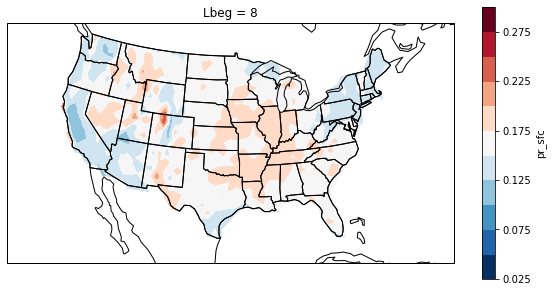

In [30]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from matplotlib.image import imread
import cartopy.io.shapereader as shpreader

shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                         category='cultural', name=shapename)
plt.figure(figsize=(10,5))
ax = plt.subplot(111,projection=ccrs.LambertConformal(central_longitude=-95, central_latitude=45) )
check_85S_LL14.pr_sfc.isel(Lbeg=0).mean('target_time').where(ds_mask.the_geom>0).plot.contourf( ax = ax,
                zorder=-1, levels=np.arange(0.025, 0.325, 0.025), cmap = 'RdBu_r',
    origin='upper', transform=ccrs.PlateCarree(),
      extent=[-180, 180, -90, 90])
# ax.stock_img()
ax.coastlines()
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
ax.add_feature(cfeature.BORDERS)
ax.add_geometries(
shpreader.Reader(states_shp).geometries(),
ccrs.PlateCarree(),
facecolor='none', edgecolor='k')


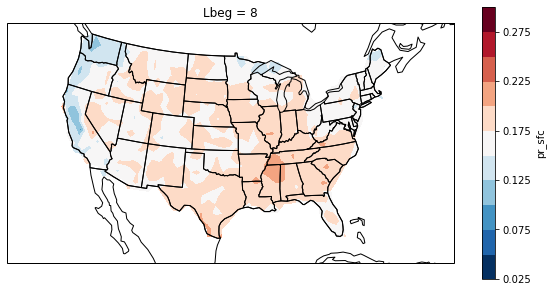

In [31]:
plt.figure(figsize=(10,5))
ax = plt.subplot(111,projection=ccrs.LambertConformal(central_longitude=-95, central_latitude=45) )
check_85S_LL4.pr_sfc.isel(Lbeg=0).mean('target_time').where(ds_mask.the_geom>0).plot.contourf( ax = ax,
                zorder=-1, levels=np.arange(0.025, 0.325, 0.025), cmap = 'RdBu_r',
    origin='upper', transform=ccrs.PlateCarree(),
      extent=[-180, 180, -90, 90])
# ax.stock_img()
ax.coastlines()
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
ax.add_feature(cfeature.BORDERS)
ax.add_geometries(
shpreader.Reader(states_shp).geometries(),
ccrs.PlateCarree(),
facecolor='none', edgecolor='k')


In [ ]:
plt.figure(figsize=(20,10))
for iL in np.arange(0,3):
    plt.figure(figsize=(10,5))
    ax = plt.subplot(111,projection=ccrs.LambertConformal(central_longitude=-95, central_latitude=45) )
    check_85S_LL4.mean('target_time').where(ds_mask.the_geom>0).isel(forecast_L=iL).plot.contourf( ax = ax,
                    zorder=-1, levels=np.arange(0.025, 0.325, 0.025), cmap = 'RdBu_r',
        origin='upper', transform=ccrs.PlateCarree(),
          extent=[-180, 180, -90, 90])
    # ax.stock_img()
    ax.coastlines()
    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
    ax.add_feature(cfeature.BORDERS)
    ax.add_geometries(
    shpreader.Reader(states_shp).geometries(),
    ccrs.PlateCarree(),
    facecolor='none', edgecolor='k')


In [ ]:
# looping through the target dates for climatologies
import warnings
warnings.filterwarnings("ignore")

# check_85LL = []
check_85S_LL = []
for iT in target_all1:
    # extract values that correspond to the target dates
    temp = all_variables_T3.where((all_variables_T3.target_time.dt.month==iT.month.values[0])&
                              (all_variables_T3.target_time.dt.day==iT.day.values[0]), drop=True)
#     smooth_data = smooth_clim_cauchy.where((smooth_clim_cauchy.target_clim.dt.month==iT.month.values[0])&
#                               (smooth_clim_cauchy.target_clim.dt.day==iT.day.values[0]), drop=True)
    smooth_data = smooth_clim_cauchy_LongL.where((smooth_clim_cauchy_LongL.target_clim.dt.month==iT.month.values[0])&
                              (smooth_clim_cauchy_LongL.target_clim.dt.day==iT.day.values[0]), drop=True)
    # bits to extract the S and t of each target_time
    y_ls = [y for (x,y) in temp.St.values]
    y_arr = np.array(y_ls)
    # loop through the 3 types of lead times
    # I have the -1 because of the way the timedelta is centered at 0 day and 12hours for day 1
#     for different_lead1, different_lead2 in zip(np.array([1,7,13])-1, np.array([5,11,17])-1 ):
    check_85b  = []
#     for different_lead1, different_lead2 in zip(np.array([2,4,6,8])-1, np.array([10,12,14,16])-1 ):
    for different_lead1, different_lead2 in zip(np.array([8,10,12])-1, np.array([8,10,12]) ):
#     for different_lead1, different_lead2 in zip(np.array([4,14])-1, np.array([22,33])-1 ):
#         print(y_arr[(y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D'))])
        temp2 = temp.sel(target_time=
                         (y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D')))
        smooth_data2 = smooth_data.sel(Lbeg=14)
#         smooth_data2 = smooth_data.sel(Lbeg=different_lead1+1)
        smooth_data2 = smooth_data2.rename({'target_clim':'target_time'})
        temp3 = temp2.stack(values = ['M','target_time'])
        diff  =  - smooth_data2.isel(target_time=0) +temp3
        diffbool = xr.where(diff.pr_sfc.where(ds_mask.the_geom>0)<0, 0,1)
        diffbool = diffbool.where(ds_mask.the_geom>0).sum('values')/diffbool.where(ds_mask.the_geom>0).count('values')
        diffbool = diffbool.expand_dims('Lbeg')
        diffbool.coords['Lbeg'] = 'Lbeg', np.atleast_1d(different_lead1+1)
        diffbool = diffbool.expand_dims('target_time')
        check_85b.append(diffbool)
    check_85b = xr.combine_by_coords(check_85b)    
#     check_85LL.append(check_85b)
    check_85S_LL.append(check_85b)
    print(iT)
check_85S_LL14 = xr.combine_by_coords(check_85S_LL)    
# check_85LL = xr.combine_by_coords(check_85LL)    


In [94]:
# looping through the target dates for climatologies
import warnings
warnings.filterwarnings("ignore")

check_85 = []
for iT in target_all1:
    # extract values that correspond to the target dates
    temp = all_variables_T3.where((all_variables_T3.target_time.dt.month==iT.month.values[0])&
                              (all_variables_T3.target_time.dt.day==iT.day.values[0]), drop=True)
#     smooth_data = smooth_clim_cauchy.where((smooth_clim_cauchy.target_clim.dt.month==iT.month.values[0])&
#                               (smooth_clim_cauchy.target_clim.dt.day==iT.day.values[0]), drop=True)
    smooth_data = smooth_clim_cauchyroll.where((smooth_clim_cauchyroll.target_clim.dt.month==iT.month.values[0])&
                              (smooth_clim_cauchyroll.target_clim.dt.day==iT.day.values[0]), drop=True)
    # bits to extract the S and t of each target_time
    y_ls = [y for (x,y) in temp.St.values]
    y_arr = np.array(y_ls)
    # loop through the 3 types of lead times
    # I have the -1 because of the way the timedelta is centered at 0 day and 12hours for day 1
#     for different_lead1, different_lead2 in zip(np.array([1,7,13])-1, np.array([5,11,17])-1 ):
    check_85b  = []
    for different_lead1, different_lead2 in zip(np.array([2,4,6,8])-1, np.array([10,12,14,16])-1 ):
#         print(y_arr[(y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D'))])
        temp2 = temp.sel(target_time=
                         (y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D')))
        smooth_data2 = smooth_data.sel(Lbeg=different_lead1+1)
        smooth_data2 = smooth_data2.rename({'target_clim':'target_time'})
        temp3 = temp2.stack(values = ['M','target_time'])
        diff  =  - smooth_data2.isel(target_time=0) +temp3
        diffbool = xr.where(diff.pr_sfc.where(ds_mask.the_geom>0)<0, 0,1)
        diffbool = diffbool.where(ds_mask.the_geom>0).sum('values')/diffbool.where(ds_mask.the_geom>0).count('values')
        diffbool = diffbool.expand_dims('Lbeg')
        diffbool.coords['Lbeg'] = 'Lbeg', np.atleast_1d(different_lead1+1)
        diffbool = diffbool.expand_dims('target_time')
        check_85b.append(diffbool)
    check_85b = xr.combine_by_coords(check_85b)    
    check_85.append(check_85b)
    print(iT)
check_85 = xr.combine_by_coords(check_85)    


DatetimeIndex(['1900-01-01'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-02'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-03'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-04'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-05'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-06'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-07'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-08'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-09'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-10'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-11'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-12'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-13'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-14'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-15'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-01-1

DatetimeIndex(['1900-05-08'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-09'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-10'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-11'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-12'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-13'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-14'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-15'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-16'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-17'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-18'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-19'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-20'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-21'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-22'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-05-2

DatetimeIndex(['1900-09-12'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-13'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-14'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-15'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-16'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-17'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-18'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-19'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-20'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-21'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-22'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-23'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-24'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-25'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-26'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1900-09-2

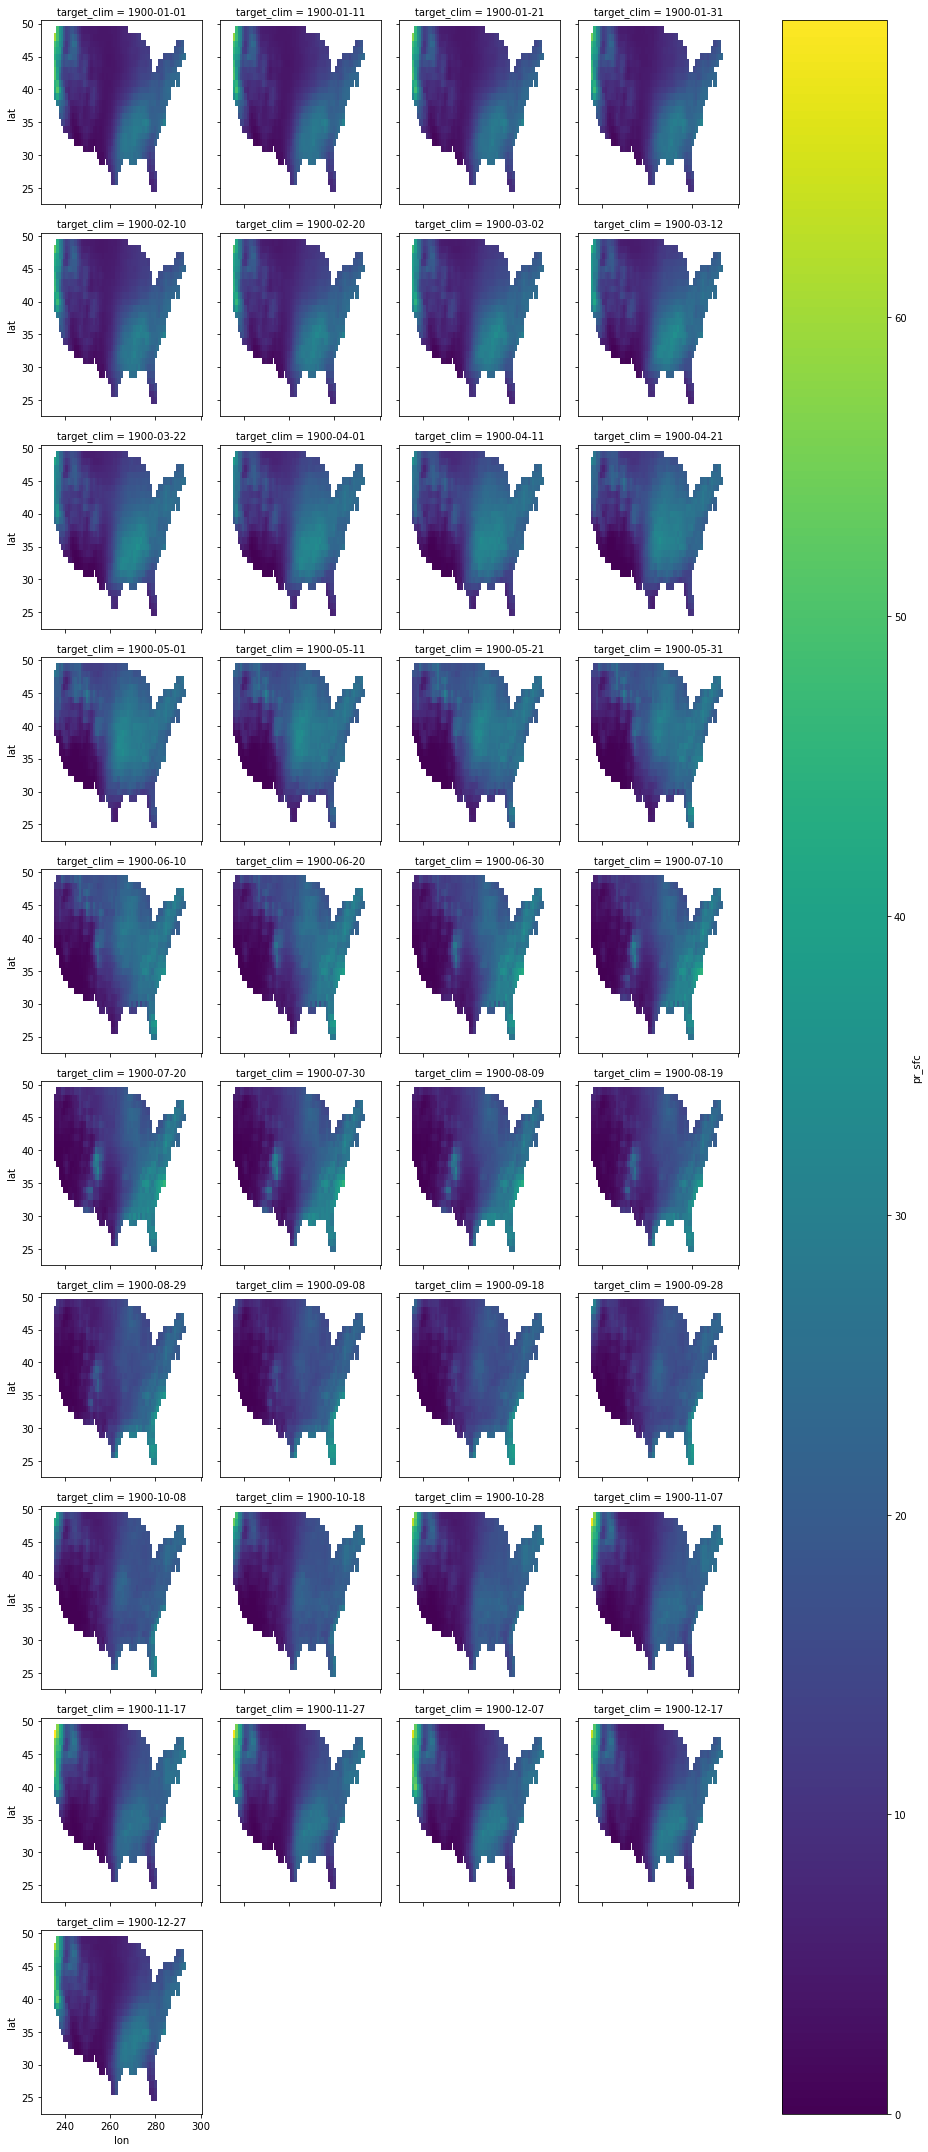

In [95]:
smooth_clim_cauchyroll.pr_sfc[::10,3].plot(col='target_clim',col_wrap=8)

In [42]:
smooth_data

<xarray.Dataset>
Dimensions:      (Lbeg: 4, lat: 28, lon: 71, target_clim: 1)
Coordinates:
  * Lbeg         (Lbeg) int64 2 4 6 8
  * lat          (lat) float64 23.0 24.0 25.0 26.0 27.0 ... 47.0 48.0 49.0 50.0
  * lon          (lon) float64 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * target_clim  (target_clim) datetime64[ns] 1900-02-08
Data variables:
    pr_sfc       (target_clim, Lbeg, lat, lon) float64 nan nan nan ... nan nan

In [54]:
diffbool

<xarray.DataArray 'pr_sfc' (target_time: 1, Lbeg: 1, lat: 28, lon: 71)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * lat          (lat) float64 23.0 24.0 25.0 26.0 27.0 ... 47.0 48.0 49.0 50.0
  * Lbeg         (Lbeg) int64 8
  * lon          (lon) float64 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * target_time  (target_time) datetime64[ns] 1900-01-01

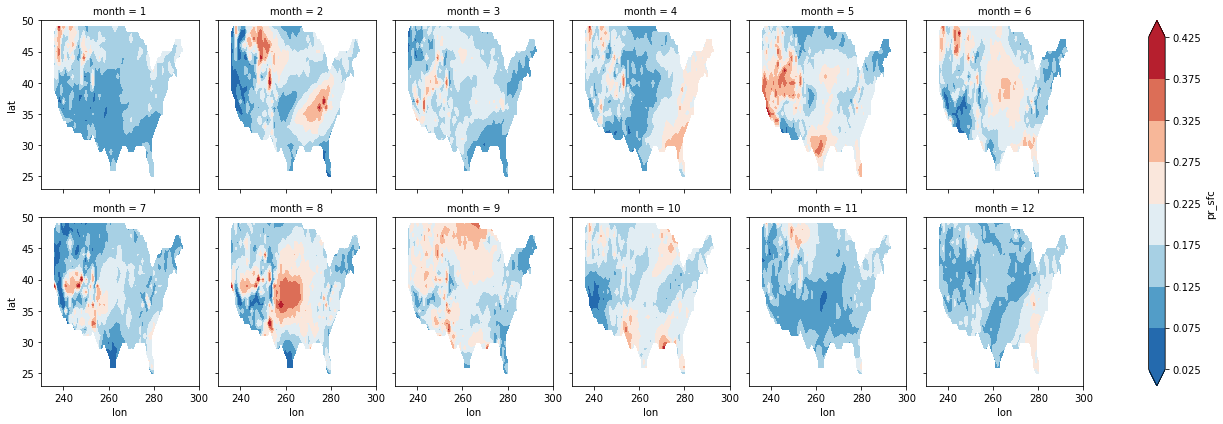

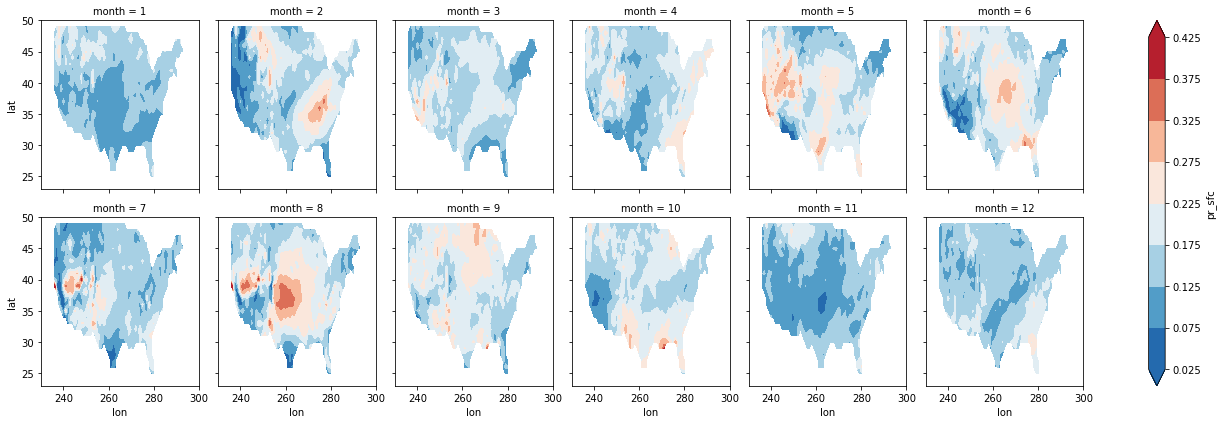

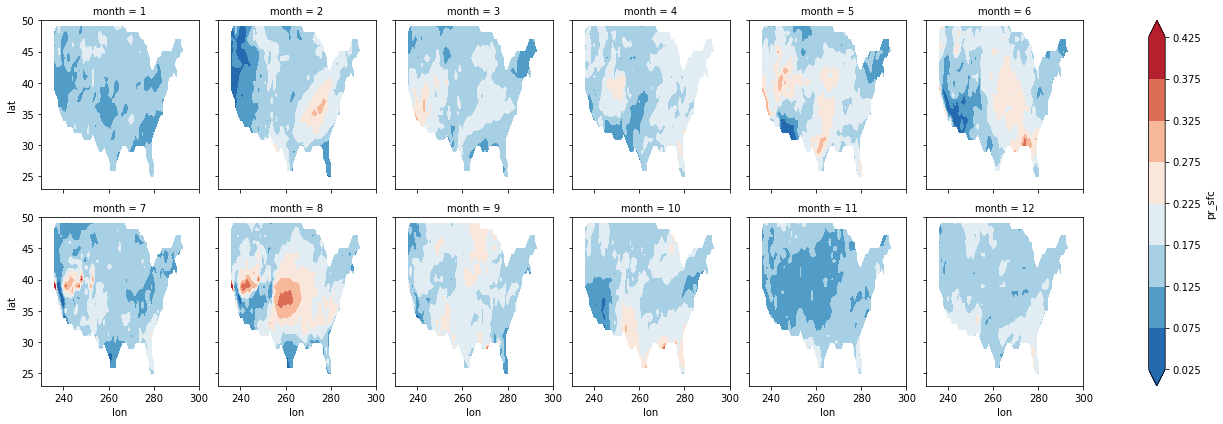

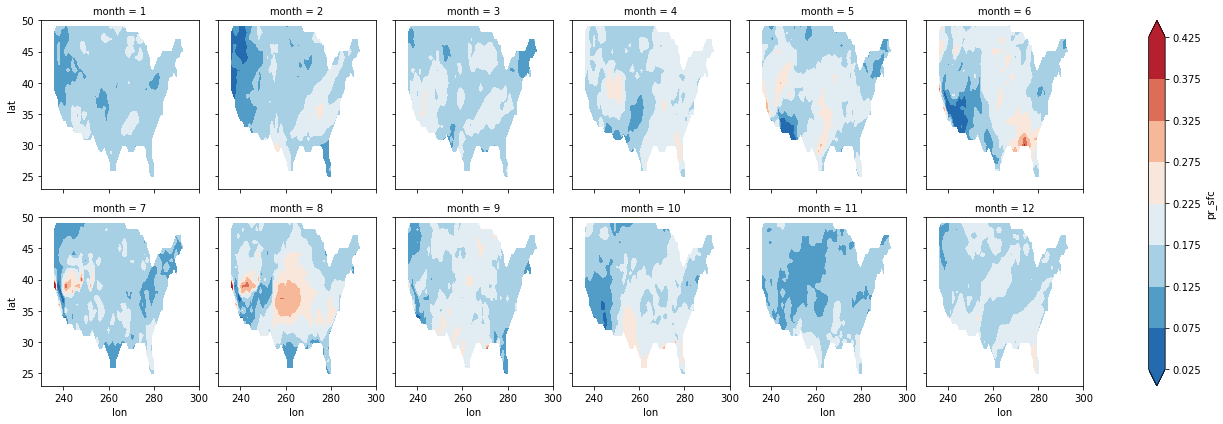

In [53]:
for il in np.arange(0,4):
    check_85S_LL14.groupby('target_time.month').mean().pr_sfc[:,il].where(ds_mask.the_geom>0).plot.contourf(
        col='month', col_wrap=6, levels=np.arange(0.025, 0.45, 0.05), cmap = 'RdBu_r')

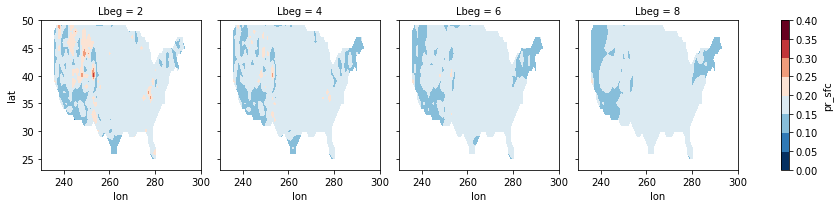

In [55]:
check_85S_LL14.groupby('target_time.year').mean().pr_sfc.where(ds_mask.the_geom>0)[0,:].plot.contourf(
        col='Lbeg', levels=np.arange(0, 0.45, 0.05), cmap = 'RdBu_r')

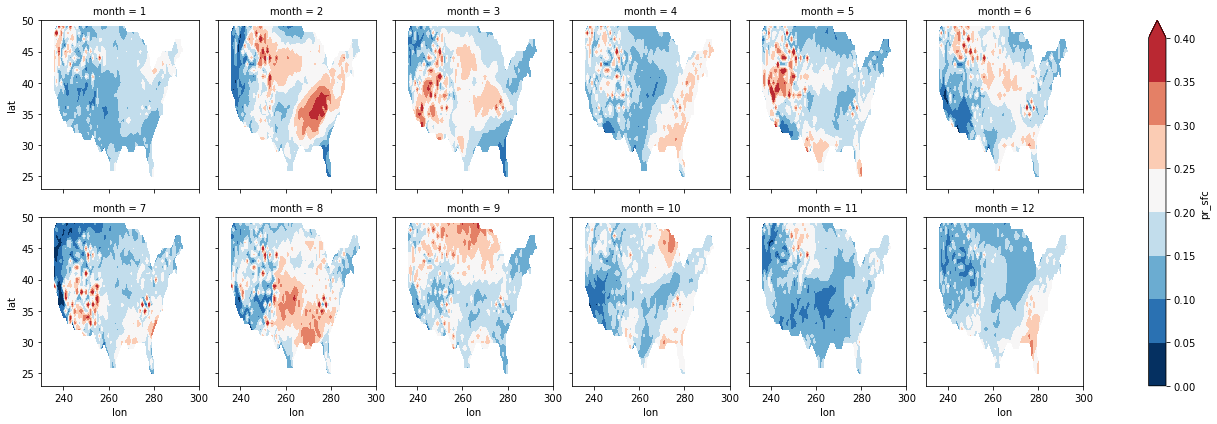

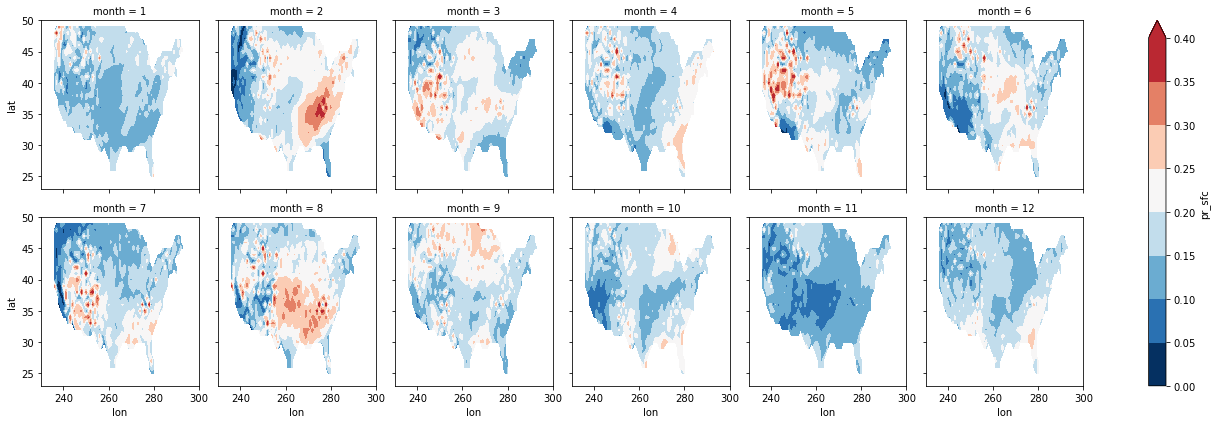

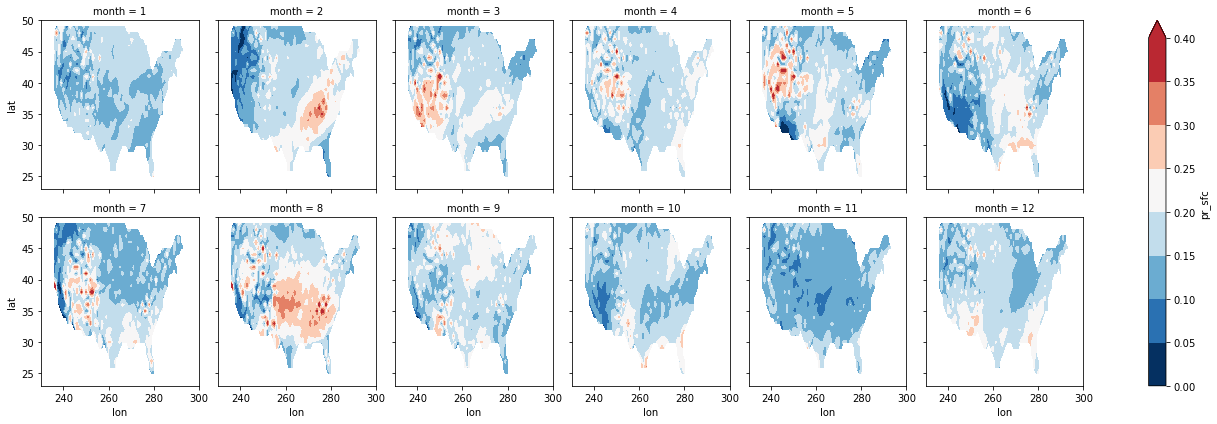

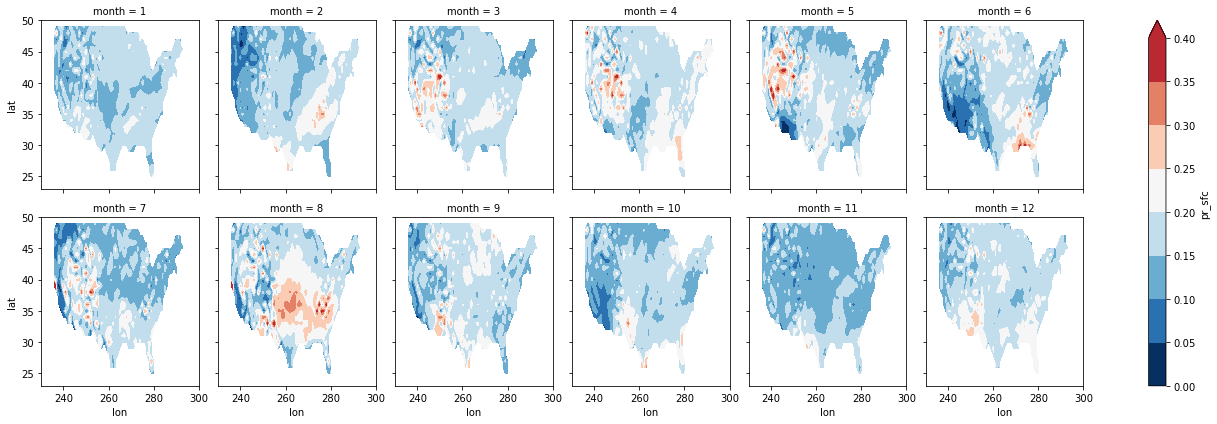

In [96]:
for il in np.arange(0,4):
    check_85.groupby('target_time.month').mean().pr_sfc[:,il].where(ds_mask.the_geom>0).plot.contourf(
        col='month', col_wrap=6, levels=np.arange(0, 0.45, 0.05), cmap = 'RdBu_r')

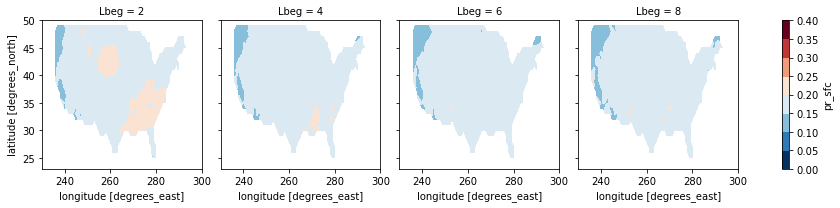

In [61]:
check_85.groupby('target_time.year').mean().pr_sfc.where(ds_mask.the_geom>0)[0,:].plot.contourf(
        col='Lbeg', levels=np.arange(0, 0.45, 0.05), cmap = 'RdBu_r')

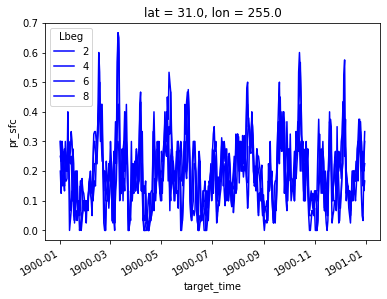

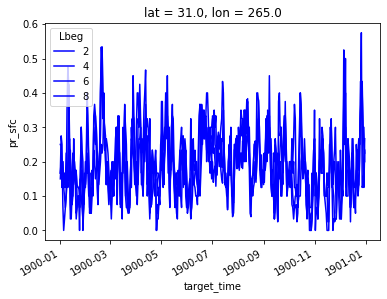

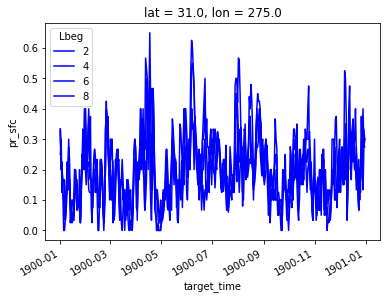

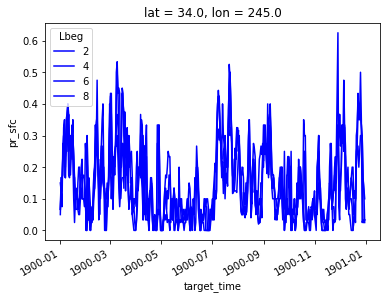

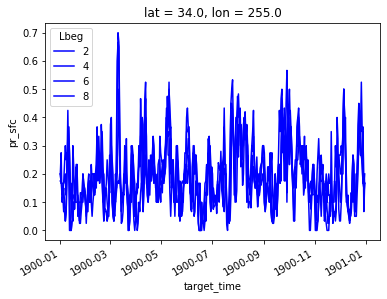

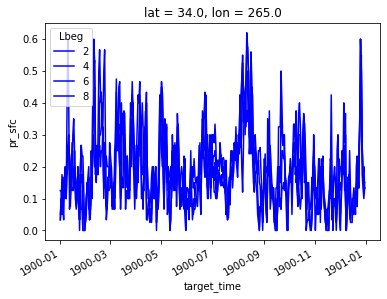

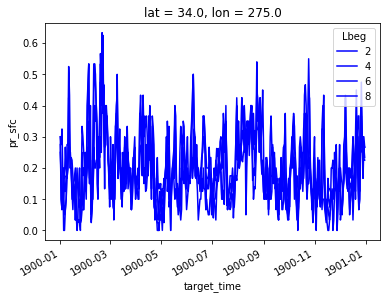

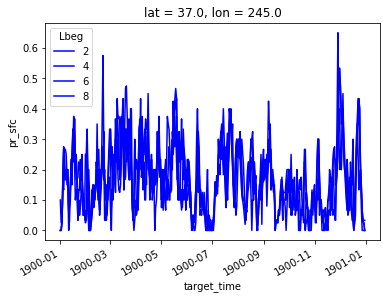

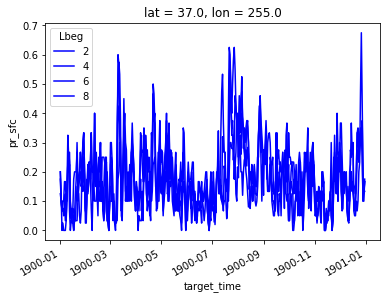

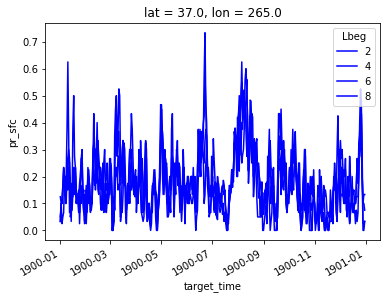

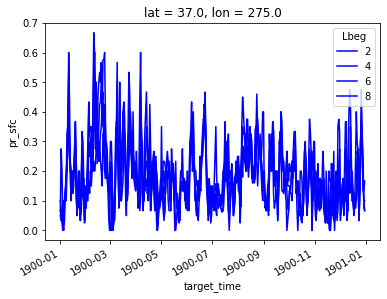

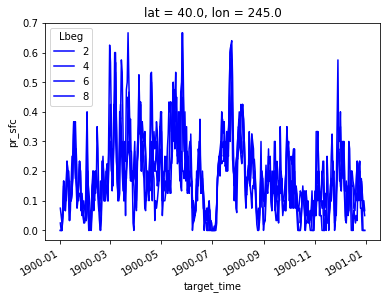

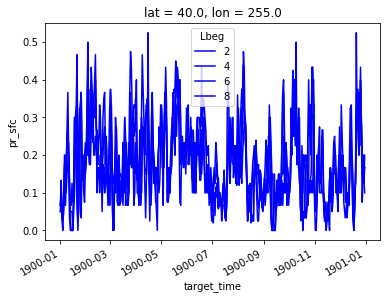

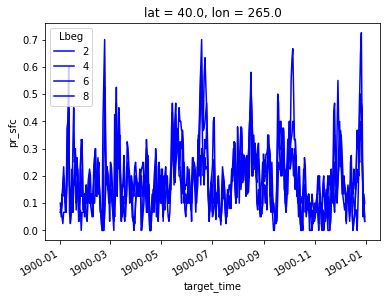

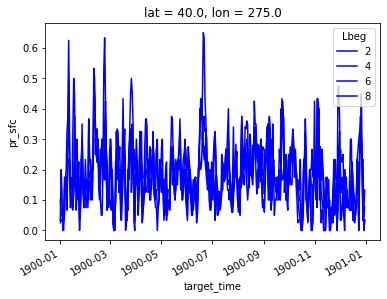

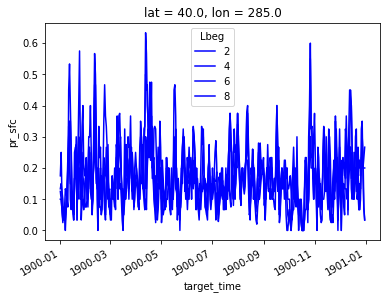

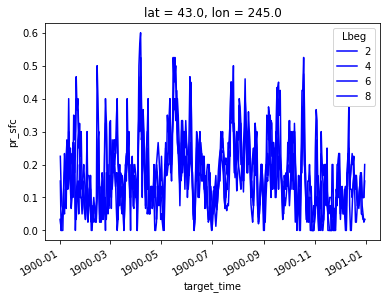

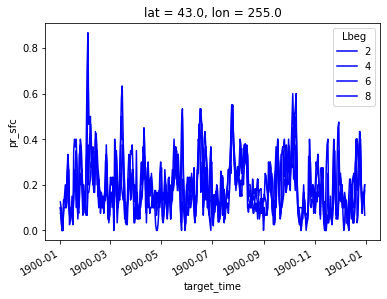

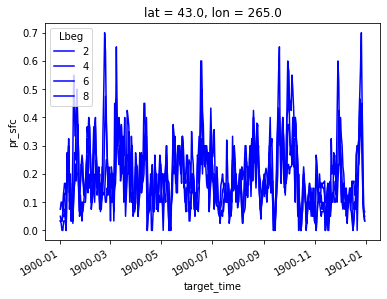

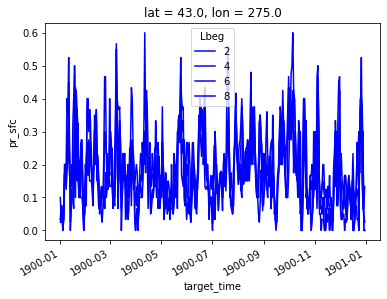

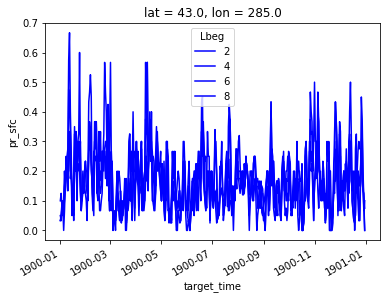

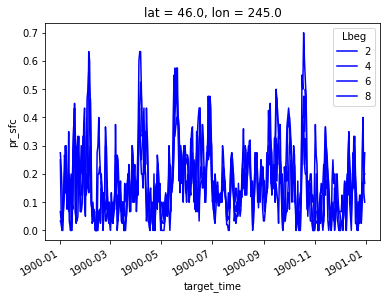

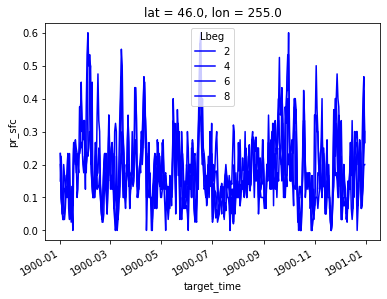

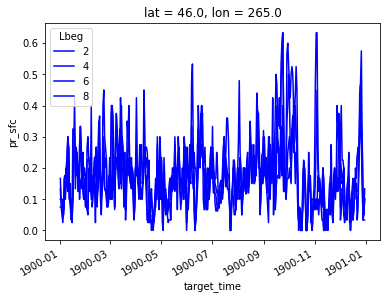

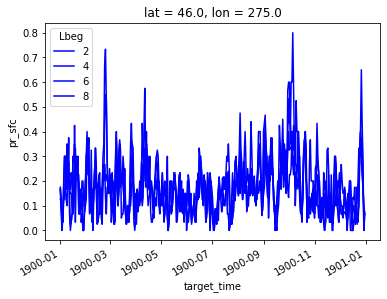

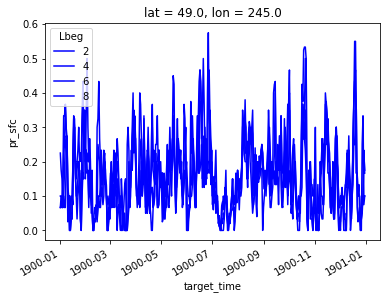

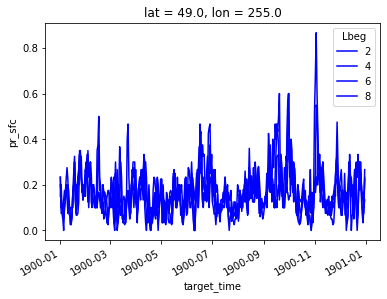

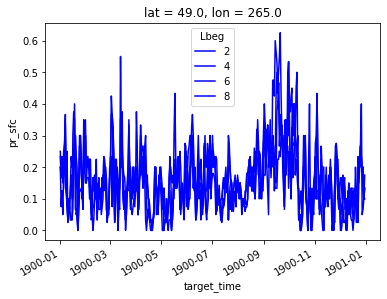

In [50]:
for ilat in np.arange(25,51,3):
    for ilon in np.arange(235,301,10):
        if np.sum(np.isnan(ds_mask.the_geom.where(ds_mask.the_geom>0).sel(lat=ilat, lon=ilon).values))==0:
            check_85.pr_sfc[:,:,:,:].sel(lat=ilat, lon=ilon).plot.line(ax = ax, x='target_time')
